## Source: Guilia Savorgnan https://www.kaggle.com/giuliasavorgnan/start-here-beginner-intro-to-lung-opacity-s1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle

datapath = os.environ.get("TRAINML_DATA_PATH")

# Lung Radiograph Images
The folder *stage_1_train_images* contains one image per patient, for a total of 25684 images.

In [3]:
# counting the number of files in the image folder
!ls ../input/stage_2_train_images/ | wc

  26684   26684 1094044


# Bounding Boxes and Target Label Data
The file *stage_1_train_labels.csv* contains the main training dataset, including the patiend ID, the bounding box coordinates, and the target label [0,1]. There can be multiple rows for the same patient ID, as each row corresponds to one observation (one box) per patient. 
There are 28989 total boxes, and 25684 unique patient IDs. The negative/positive Target split is roughly 70-30%.

In [5]:
df_box = pd.read_csv(datapath+'/stage_2_train_labels.csv')
print('Number of rows (unique boxes per patient) in main train dataset:', df_box.shape[0])
print('Number of unique patient IDs:', df_box['patientId'].nunique())
df_box.head(6)

Number of rows (unique boxes per patient) in main train dataset: 30227
Number of unique patient IDs: 26684


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Target
0    0.683892
1    0.316108
dtype: float64


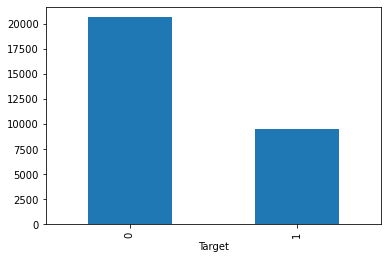

In [6]:
df_box.groupby('Target').size().plot.bar()
print(df_box.groupby('Target').size() / df_box.shape[0])

# Detailed Class Info Data
The file *stage_1_detailed_class_info.csv* contains detailed information about the positive and negative classes in the training set, and may be used to build more nuanced models. As in the main training dataset, this auxiliary dataset contains 28989 rows and 25684 unique patient IDs. 
There's 3 classes: 
    1. Normal (29%)
    2. No Lung Opacity / Not Normal (40%)
    3. Lung Opacity (31%)
The first two classes correspond to Target = 0, whereas the third class correspond to Target = 1.

In [8]:
df_aux = pd.read_csv(datapath+'/stage_2_detailed_class_info.csv')
print('Number of rows in auxiliary dataset:', df_aux.shape[0])
print('Number of unique patient IDs:', df_aux['patientId'].nunique())
df_aux.head(6)

Number of rows in auxiliary dataset: 30227
Number of unique patient IDs: 26684


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


class
Lung Opacity                    0.316108
No Lung Opacity / Not Normal    0.391074
Normal                          0.292818
dtype: float64


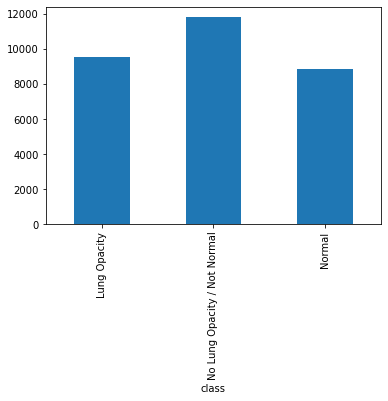

In [9]:
df_aux.groupby('class').size().plot.bar()
print(df_aux.groupby('class').size() / df_aux.shape[0])
assert df_box.loc[df_box['Target']==0].shape[0] == df_aux.loc[df_aux['class'].isin(['Normal', \
    'No Lung Opacity / Not Normal'])].shape[0], 'Number of negative targets does not match between main and auxiliary dataset.'
assert df_box.loc[df_box['Target']==1].shape[0] == df_aux.loc[df_aux['class'] == 'Lung Opacity'].shape[0], \
    'Number of positive targets does not match between main and auxiliary dataset.'

# Merging Main (Boxes) and Auxiliary (Classes) Datasets
The main and auxiliary datasets do not share a joining keyword column, but it seems obvious that the rows are listed in the exact same order (check the patient Id columns to convince yourself), therefore we can combine the two dataframes by concatenating their columns.

In [10]:
assert df_box['patientId'].values.tolist() == df_aux['patientId'].values.tolist(), 'PatientId columns are different.'
df_train = pd.concat([df_box, df_aux.drop(labels=['patientId'], axis=1)], axis=1)
df_train.head(6)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity


Just for peace of mind, we can check that there is a unique correspondence between Target and class labels.

In [11]:
df_train.groupby(['class', 'Target']).size()

class                         Target
Lung Opacity                  1          9555
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
dtype: int64

NaN values are only present in the box coordinates columns, as expected.

In [12]:
df_train.isnull().any()

patientId    False
x             True
y             True
width         True
height        True
Target       False
class        False
dtype: bool

We can also make sure that positive targets are all associated with (non-NaN) box coordinates and viceversa.

In [13]:
# when target==1, are any of the box coordinates null? (should all be false)
df_train.loc[df_train['Target']==1, ['x', 'y', 'width', 'height']].isnull().any()

x         False
y         False
width     False
height    False
dtype: bool

In [14]:
# when target==0, are all of the box coordinates null? (should all be true)
df_train.loc[df_train['Target']==0, ['x', 'y', 'width', 'height']].isnull().all()

x         True
y         True
width     True
height    True
dtype: bool

# Radiograph Images
The radiograph images are stored in the folder *stage_1_train_images*. The images are saved in DICOM format (*.dcm*), which includes a header of meta-data and the raw pixel image itself. Images are named using their corrsponding patient ID. Images can be read in and modified using the library [pydicom](https://pydicom.github.io/). The headers of meta-data have been mostly anonymized for patient privacy, but they still contain a bunch of useful information that could be used to improve the classification model. The raw pixel images are stored in 1024x1024 8-bit encoded (=2^8=256 gray-scales) numpy arrays.

In [15]:
# sample of image filenames
!ls -U ../input/stage_2_train_images/ | head -6

610bb23b-30af-4868-8d53-f90cda513fc6.dcm
4c445a68-b7af-455c-b8f0-a94a4cc6eb13.dcm
e88711cb-e03b-4570-a531-8ac8a7f9c6f5.dcm
6635be9a-ebe6-4c2c-953d-2ef1f8d65df1.dcm
dfd5309e-412e-475c-8e8e-25f31f7d1091.dcm
604a6a95-e65c-43c4-b12d-7045ad92e54b.dcm
ls: write error: Broken pipe


In [16]:
# check that there is an image for each unique patient ID
assert sorted(df_train['patientId'].unique().tolist()) == sorted([f[:-4] for f in os.listdir(datapath+'/stage_2_train_images/')]), \
    'Discrepancy between patient IDs and radiograph images.'

In [18]:
# have a look at the header meta-data of an image 
pId = df_train['patientId'].sample(1).values[0]    
dcmdata = pydicom.read_file(datapath+'/stage_2_train_images/'+pId+'.dcm')
print(dcmdata)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.22974.1517874444.854868
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.22974.1517874444.854868
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [19]:
# extract the raw pixel image and look at its properties
dcmimg = dcmdata.pixel_array
print(type(dcmimg))
print(dcmimg.dtype)
print(dcmimg.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

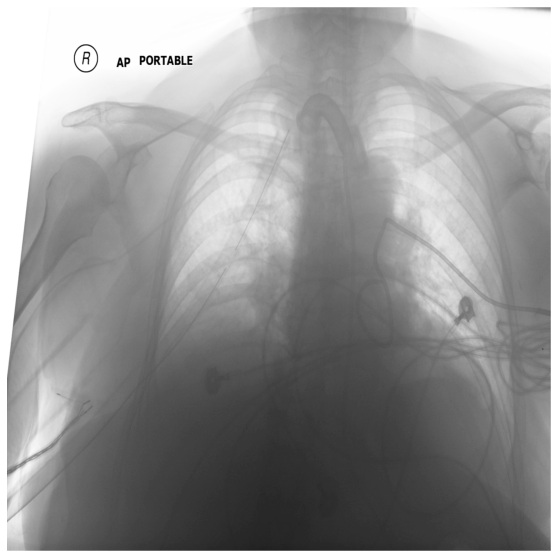

In [20]:
# visualize the corresponding radiograph image
plt.figure(figsize=(20,10))
plt.imshow(dcmimg, cmap=pylab.cm.binary)
plt.axis('off')

# Define utility functions for visualization
Below we define a bunch of useful functions to overlay images with boxes and labels.

In [21]:
def get_boxes_per_patient(df, pId):
    '''
    Given the dataset and one patient ID, 
    return an array of all the bounding boxes and their labels associated with that patient ID.
    Example of return: 
    array([[x1, y1, width1, height1, class1, target1],
           [x2, y2, width2, height2, class2, target2]])
    '''
    
    boxes = df.loc[df['patientId']==pId][['x', 'y', 'width', 'height', 'class', 'Target']].values
    return boxes

In [25]:
def get_dcm_data_per_patient(pId, sample='train'):
    '''
    Given one patient ID and the sample name (train/test), 
    return the corresponding dicom data.
    '''
    return pydicom.read_file(datapath+'/stage_2_'+sample+'_images/'+pId+'.dcm')

In [26]:
def display_image_per_patient(df, pId, angle=0.0, sample='train'):
    '''
    Given one patient ID and the dataset,
    display the corresponding dicom image with overlaying boxes and class annotation.
    To be implemented: Optionally input the image rotation angle, in case of data augmentation.
    '''
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    dcmimg = dcmdata.pixel_array
    boxes = get_boxes_per_patient(df, pId)
    plt.figure(figsize=(20,10))
    plt.imshow(dcmimg, cmap=pylab.cm.binary)
    plt.axis('off')
    
    class_color_dict = {'Normal' : 'green',
                        'No Lung Opacity / Not Normal' : 'orange',
                        'Lung Opacity' : 'red'}

    if len(boxes)>0:
        for box in boxes:
            # extracting individual coordinates and labels
            x, y, w, h, c, t = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', 
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            plt.gca().add_patch(patch)
            
    # add annotation text
    plt.text(10, 50, c, color=class_color_dict[c], size=20, 
             bbox=dict(edgecolor=class_color_dict[c], facecolor='none', alpha=0.5, lw=2))
            

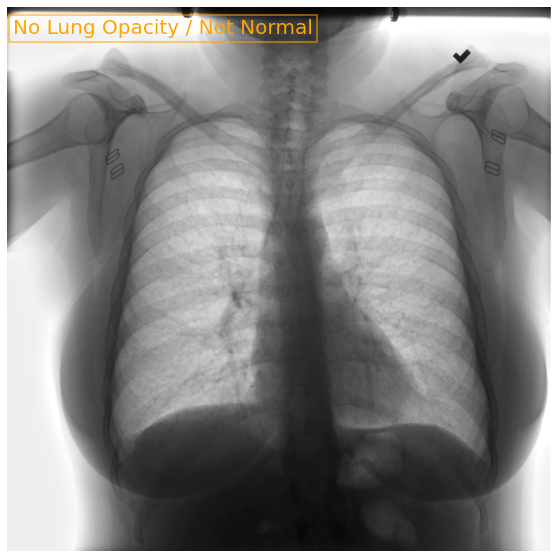

In [27]:
# run this cell multiple times to visualize different examples
pId = df_train['patientId'].sample(1).values[0]    
display_image_per_patient(df_train, pId, sample='train')

# Extract useful meta-data from dicom headers
We can extract some information from the image headers and add it to the training dataset, so that we can check for possible correlations with the target.

In [28]:
def get_metadata_per_patient(pId, attribute, sample='train'):
    '''
    Given a patient ID, return useful meta-data from the corresponding dicom image header.
    Return: 
    attribute value
    '''
    # get dicom image
    dcmdata = get_dcm_data_per_patient(pId, sample=sample)
    # extract attribute values
    attribute_value = getattr(dcmdata, attribute)
    return attribute_value

In [29]:
# create list of attributes that we want to extract (manually edited after checking which attributes contained valuable information)
attributes = ['PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    df_train[a] = df_train['patientId'].apply(lambda x: get_metadata_per_patient(x, a, sample='train'))
# convert patient age from string to numeric
df_train['PatientAge'] = df_train['PatientAge'].apply(pd.to_numeric, errors='coerce')
# remove a few outliers
df_train['PatientAge'] = df_train['PatientAge'].apply(lambda x: x if x<120 else np.nan)
df_train.head()

,patientId,x,y,width,height,Target,class,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,F,32.0,AP


In [30]:
# look at age statistics between positive and negative target groups
df_train.drop_duplicates('patientId').groupby('Target')['PatientAge'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,20667.0,47.425848,16.513969,1.0,35.0,50.0,60.0,92.0
1,6012.0,45.582502,17.468836,1.0,32.0,47.0,58.0,92.0


In [31]:
# look at gender statistics between positive and negative target groups
df_train.drop_duplicates('patientId').groupby(['PatientSex', 'Target']).size() / df_train.drop_duplicates('patientId').groupby(['PatientSex']).size()

PatientSex  Target
F           0         0.782775
            1         0.217225
M           0         0.768561
            1         0.231439
dtype: float64

In [32]:
# look at patient position statistics between positive and negative target groups
df_train.drop_duplicates('patientId').groupby(['ViewPosition', 'Target']).size() / df_train.drop_duplicates('patientId').groupby(['ViewPosition']).size()

ViewPosition  Target
AP            0         0.616857
              1         0.383143
PA            0         0.907105
              1         0.092895
dtype: float64

In [33]:
# absolute split of view position
df_train.groupby('ViewPosition').size()

ViewPosition
AP    15297
PA    14930
dtype: int64

### **Age and gender - individually - do not seem to be correlated with the target. However, the view position of the radiograph image appears to be really important in terms of target split. AP means Anterior-Posterior, whereas PA means Posterior-Anterior. This [webpage](https://www.med-ed.virginia.edu/courses/rad/cxr/technique3chest.html) explains that "Whenever possible the patient should be imaged in an upright PA position.  AP views are less useful and should be reserved for very ill patients who cannot stand erect". One way to interpret this target unbalance in the ViewPosition variable is that patients that are imaged in an AP position are those that are more ill, and therefore more likely to have contracted pneumonia. Note that the absolute split between AP and PA images is about 50-50, so the above consideration is extremely significant. **

# Extract Test Images Metadata

In [34]:
patientIDs_test = [f[:-4] for f in os.listdir(datapath+'/stage_2_test_images/')]
df_test = pd.DataFrame(data={'patientId' : patientIDs_test})

In [35]:
attributes = ['PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    df_test[a] = df_test['patientId'].apply(lambda x: get_metadata_per_patient(x, a, sample='test'))
# convert patient age from string to numeric
df_test['PatientAge'] = df_test['PatientAge'].apply(pd.to_numeric, errors='coerce')
# remove a few outliers
df_test['PatientAge'] = df_test['PatientAge'].apply(lambda x: x if x<120 else np.nan)
df_test.head()

,patientId,PatientSex,PatientAge,ViewPosition
0,313ce9b9-3fe4-4354-aea7-707eee7db3ab,M,65.0,AP
1,25fdf103-c49f-4837-a2b2-b0691ca3d877,F,33.0,PA
2,2470255f-acf9-4842-97e9-37f7937c92f9,F,34.0,PA
3,0e40c8e1-dd94-4ccf-8bf1-8938377704df,M,58.0,AP
4,1c806439-d6a9-40ff-a969-7f6cd116ac2d,F,43.0,AP


In [36]:
# save dataframes
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)